<a href="https://colab.research.google.com/github/danibosch/mentoria-diplo-datos2021/blob/main/Cintelink_AyVdD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<small>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones, FaMAF UNC, 2021.</small>
# Análisis y Visualización de Datos 

Este trabajo pertenece a la mentoría **GAP: Gestión Automática de Pedidos de Combustibles Líquidos basada en telemetría de inventarios**.

Integrantes:
- Bernaschini, María Laura
- Bosch, Daniela
- Rodríguez, Martín

## Introducción

Para alcanzar los objetivos propuestos en el proyecto, será necesario comprender el dataset, tomar sensibilidad y definir criterios del dominio para tomar decisiones sobre los procesos de curación, selección de modelos y realizar ingeniería de features si hiciera falta. En este práctico deberemos descubrir los patrones de manejo de inventarios y consumos por industria. Buscaremos una sugerencia de una solución básica para estimar inventarios de corto plazo.

### Sobre el dataset

El dataset está conformado por el historial de inventarios de tanques en sitios de diferentes empresas. Se trata de información real de centros operativos distribuidos en Argentina y algunos otros países. Los historiales son del primer trimestre de 2021. Los datos provienen de **sensores de nivel magnetostrictivos** colocados en los tanques de los centros operativos. Los datos son almacenados en servidores sin demasiada curación. Pueden contener errores. Puede haber datos faltantes en algunos casos.

La principal información del dataset es el `volumen` medido en los tanques durante el paso del tiempo (`timestamp`). Sin embargo, features como `temperatura`, `codigo`, `producto`, `id_equipo`, `id_tanque`, `capacidad`, `industria`, permiten realizar un tratamiento de los datos para agruparlos y caracterizarlos, lo cual es necesario para comprender el dataset y luego entrenar un modelo de estimación generalista con hiperparámetros o features adicionales.

In [ ]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn
from datetime import datetime, timedelta

seaborn.set_context('talk')
# Set float format
pd.set_option('display.float_format','{:.2f}'.format)

# Set style
seaborn.set_style("darkgrid")
seaborn.set_palette('pastel')
seaborn.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12}) 

## Lectura del dataset



Como se trata de un dataset de gran tamaño debemos hacer algunas conversiones antes de leerlo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def convert2float32(n):
    try:
        return numpy.float32(n)
    except:
        return numpy.nan

def convert2float16(n):
    try:
        return numpy.float16(n)
    except:
        return numpy.nan

def convert2int16(n):
    try:
        return numpy.int16(n)
    except:
        return numpy.nan

def convert2int8(n):
    try:
        return numpy.int8(n)
    except:
        return numpy.nan

In [ ]:
dtypes = {
    "id": "category",
    "id_equipo": "category",
    "id_tanque": "category",
    "producto": "category",
    "id_empresa": "category",
    "id_canal": "category",
    "nombre_producto": "category",
    "industria": "category",
    "alarma": "boolean"
}

# Para evitar datos erróneos en el parsing
converters = {
    "id_industria": convert2float16,
    "volumen": convert2float32,
    "vbat1": convert2int16,
    "vbat2": convert2int16,
    "capacidad": convert2float32,
    "fuel_level_dmm": convert2float32,
    "water_level_dmm": convert2float32,
    "water_volume_lts": convert2float32,
    "temp5": convert2float16,
    "temp4": convert2float16,
    "temp3": convert2float16,
    "temp2": convert2float16,
    "temp1": convert2float16,
    "temperatura": convert2float16,
    "coef_var_vol": convert2float16,
    "density": convert2float32
}

In [ ]:
# filename = '/content/drive/MyDrive/Colab Notebooks/DiploDatos/Mentoría/Datasets/dataset100mil.csv'
filename = '/content/drive/MyDrive/Colab Notebooks/DiploDatos/Mentoría/Datasets/StorageInventory_2021_Q1.csv'
raw_df = pd.read_csv(
    filename, 
    converters=converters, 
    dtype=dtypes, 
    parse_dates=["timestamp"],
    index_col=0
)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
raw_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10148505 entries, 0 to 10148504
Data columns (total 28 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                category      
 1   id_equipo         category      
 2   id_tanque         category      
 3   volumen           float64       
 4   temperatura       float64       
 5   codigo            object        
 6   vbat1             int64         
 7   vbat2             int64         
 8   fuel_level_dmm    float64       
 9   water_level_dmm   float64       
 10  water_volume_lts  float64       
 11  producto          category      
 12  temp5             float64       
 13  temp4             float64       
 14  temp3             float64       
 15  temp2             float64       
 16  temp1             float64       
 17  id_empresa        category      
 18  current_firmware  object        
 19  id_canal          category      
 20  id_industria      float64       
 21  indust

In [ ]:
raw_df.head()

,id,id_equipo,id_tanque,volumen,temperatura,codigo,vbat1,vbat2,fuel_level_dmm,water_level_dmm,water_volume_lts,producto,temp5,temp4,temp3,temp2,temp1,id_empresa,current_firmware,id_canal,id_industria,industria,capacidad,alarma,nombre_producto,coef_var_vol,density,timestamp
0,47936,430,964,17143.94,25.00,N1,67,357,9217.00,0.00,0.00,0,25.00,25.59,23.91,22.30,22.09,36,V61005a1b2e477d,4,1.00,Transportation,50191.00,False,Product 1,0.00,nan,2021-01-01 00:00:46
1,1906999,477,1014,16200.70,26.09,N1,67,304,15727.00,0.00,0.00,3,26.09,26.09,26.59,29.09,-56.59,100,V60603bQ74df1d3,4,6.00,Service Station,21259.00,True,Formula Diesel,0.00,nan,2021-01-01 00:00:24
2,1907000,477,1013,11265.10,25.70,N1,66,297,11579.00,0.00,0.00,2,25.70,-56.59,-56.59,-56.59,-56.59,100,V60603bQ74df1d3,4,6.00,Service Station,15032.00,True,VP Diesel,0.00,0.00,2021-01-01 00:00:31
3,1907001,477,1010,865.65,24.80,N1,66,302,1865.00,0.00,0.00,0,24.80,25.91,26.00,26.59,-56.59,100,V60603bQ74df1d3,4,6.00,Service Station,15032.00,True,VP Nafta,0.00,0.00,2021-01-01 00:00:38
4,1907002,477,1011,1929.49,26.00,N1,61,272,3255.00,0.00,0.00,1,26.00,-56.59,-56.59,-56.59,-56.59,100,V60603bQ74df1d3,4,6.00,Service Station,15032.00,True,Super,0.00,nan,2021-01-01 00:00:41


## Limpieza de datos

Antes de analizar cada una de las features de dataset, debemos convertir algunos tipos de datos y realizar la limpieza según distintos criterios.

### Tipo de datos de columnas

A fines de realizar correctamente el análisis y de optimizar el tamaño de nuestro dataframe realizamos algunas conversiones de tipos de acuerdo a los valores observados previamente. Luego, obtenemos una copia del mismo para no modificar la información del dataset original.

In [ ]:
raw_df['volumen'] = raw_df['volumen'].astype(numpy.float32)
raw_df['temperatura'] = raw_df['temperatura'].astype(numpy.float16)
raw_df['temp5'] = raw_df['temp5'].astype(numpy.float16)
raw_df['temp4'] = raw_df['temp4'].astype(numpy.float16)
raw_df['temp3'] = raw_df['temp3'].astype(numpy.float16)
raw_df['temp2'] = raw_df['temp2'].astype(numpy.float16)
raw_df['temp1'] = raw_df['temp1'].astype(numpy.float16)
raw_df['fuel_level_dmm'] = raw_df['fuel_level_dmm'].astype(numpy.float32)
raw_df['water_level_dmm'] = raw_df['water_level_dmm'].astype(numpy.float32)
raw_df['water_volume_lts'] = raw_df['water_volume_lts'].astype(numpy.float32)
raw_df['capacidad'] = raw_df['capacidad'].astype(numpy.float32)
raw_df['coef_var_vol'] = raw_df['coef_var_vol'].astype(numpy.float16)
raw_df['density'] = raw_df['density'].astype(numpy.float16)
raw_df['vbat1'] = raw_df['vbat1'].astype(numpy.int16)
raw_df['vbat2'] = raw_df['vbat2'].astype(numpy.int16)
raw_df['id_industria'] = raw_df['id_industria'].astype("category")
raw_df['codigo'] = raw_df['codigo'].astype("str")

In [ ]:
raw_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10148505 entries, 0 to 10148504
Data columns (total 28 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                category      
 1   id_equipo         category      
 2   id_tanque         category      
 3   volumen           float32       
 4   temperatura       float16       
 5   codigo            object        
 6   vbat1             int16         
 7   vbat2             int16         
 8   fuel_level_dmm    float32       
 9   water_level_dmm   float32       
 10  water_volume_lts  float32       
 11  producto          category      
 12  temp5             float16       
 13  temp4             float16       
 14  temp3             float16       
 15  temp2             float16       
 16  temp1             float16       
 17  id_empresa        category      
 18  current_firmware  object        
 19  id_canal          category      
 20  id_industria      category      
 21  indust

In [ ]:
# Trabajamos sobre una copia y no sobre el original
df = raw_df.copy()
len(df)

10148505

In [ ]:
# Si se llena la memoria, ejecutar
del raw_df

### Valores faltantes

Para esto observaremos las columnas de interés `volumen`, `codigo` y `temperatura`. Vemos además, si se observan intersecciones entre estos conjuntos.



In [ ]:
# Análisis de intersección nan entre variables
df[df['temperatura'].isna() & df['codigo'].isna() & df['fuel_level_dmm'].isna()]

Eliminamos los valores nulos que se observan en nuestra variable de interés `volumen`, ya que sin estos no es posible realizar ningún cálculo sonre inventarios y consumos.

También decidimos eliminar aquellas `temperatura`s que tengan valores nulos, ya que el volumen se ve afectado por la misma (relación que se verá más adelante).

Por último, no tuvimos en cuenta los valores nulos de `codigo` porque inferimos que el sensor no está funcionando y esto coincide con la existencia de valures nulos de temperatura y de nivel de combustible.

In [ ]:
nan = numpy.nan

# Volúmenes nulos
df = df.query("volumen != @nan")

# Temperaturas nulas
df = df.query("temperatura != @nan")

# Códigos nulos
df = ~df['codigo'].isna()

len(df)

### Eliminación de outliers

#### Filtrado de valores erróneos
A partir de la exploración de los datos definimos algunos criterios para el filtrado de nuestra base de datos. Por un lado, pudimos observar que la variable `volumen` posee valores mínimos negativos y que su máximo valor sobrepasa el valor máximo de la capacidad de los tanques, por lo que difinimos la primera y segunda condición de filtrado (`cond_1` y `cond_2`) y nos quedamos con valores de volúmenes mayores o iguales a cero y menores a la capacidad máxima. Por otro lado, vimos que cuando la carga de alguna de las dos baterías es cero el nivel de combustible también es cero o produce valores nulos (nan) por lo que no se estaría estimando correctamente el valor de volumen, definiendo de esta manera las condidiones 3 y 4 (`cond_3` y `cond_4`).

In [ ]:
# Volúmenes negativos
cond_1 = df["volumen"] >= 0

# Volúmenes mayores a la capacidad del tanque
cond_2 = df["volumen"] < df["capacidad"].max()

# Voltaje del pulso de eco 0
cond_3 = df["vbat1"] != 0

# Batería con voltaje 0
cond_4 = df["vbat2"] != 0

In [ ]:
df = df[cond_1 & cond_2 & cond_3 & cond_4]
len(df)

10140141

In [ ]:
df.info()

In [ ]:
df.describe().round()

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(15,9),gridspec_kw={"height_ratios": (.15, .85)})
 
seaborn.boxplot(df.volumen, ax=ax_box)
seaborn.distplot(df.volumen, ax=ax_hist, kde=False, hist=False)
seaborn.distplot(df.volumen, ax=ax_hist, kde=True, hist=True,norm_hist=False)

plt.axvline(df.volumen.quantile(0.25))
plt.axvline(df.volumen.quantile(0.50),color='g')
plt.axvline(df.volumen.quantile(0.75))
plt.ticklabel_format(style='plain', axis='x') 
plt.axvline(df.volumen.mean(),color='red') 
ax_box.set_title
plt.show()

#### Filtrado teniendo en cuenta el rango intercuartílico

In [ ]:
q1 = df.volumen.quantile(0.25)
q3 = df.volumen.quantile(0.75)
RI = q3 - q1
min = q1 - 2.5*RI
max = q3 + 2.5*RI
print("Límite inferior =", min)
print("Límite superior =", max)

Límite inferior = -21873.07275390625
Límite superior = 34603.90185546875


In [ ]:
df = df[df.volumen < max]
len(df)

9885016

#### Filtrado teniendo en cuenta el la desviación estándar

In [ ]:
vol_mean = df.volumen.mean()
vol_std = df.volumen.std()
min_s = vol_mean - 2.5 * vol_std
max_s = vol_mean + 2.5 * vol_std
print("Límite inferior =", min_s)
print("Límite superior =", max_s)

Límite inferior = -10803.3701171875
Límite superior = 24353.5927734375


In [ ]:
df = df[df.volumen < max_s]
len(df)

9535214

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(15,9),gridspec_kw={"height_ratios": (.15, .85)})
 
seaborn.boxplot(df.volumen, ax=ax_box)
seaborn.distplot(df.volumen, ax=ax_hist, kde=False, hist=False)
seaborn.distplot(df.volumen, ax=ax_hist, kde=True, hist=True,norm_hist=False)

plt.axvline(df.volumen.quantile(0.25))
plt.axvline(df.volumen.quantile(0.50),color='g')
plt.axvline(df.volumen.quantile(0.75))
plt.ticklabel_format(style='plain', axis='x') 
plt.axvline(df.volumen.mean(),color='red') 
ax_box.set_title
plt.show()

#### Filtrado de registros con códigos de error

Quitamos aquellos registros que contengan códigos de error. Para esto, separamos la columna `codigo` en dos campos, ya que la misma contiene además información de la cantidad de ecos.

Se deja la [documentación](https://drive.google.com/file/d/1IURbnJ3305CLaJSrvjP2E7_ab9mfdg6r/view) sobre los significados de estos códigos.

In [ ]:
df['codigo'].unique()

array(['N1', 'N2', 'F1', 'N0', 'V1', 'F0', 'm0', 'M1', 'F2', 'L1', 'V0',
       'I2', 'V2', 'U2', 'L2', 'I1', 'U1', 'P1', 'I0', 'T1', 'P2', 'T0',
       'M2', 'L0', 'L3', 'V6', 'V5', 'V3', 'L4', 'V4', 'N3', 'm1', 'N4',
       'U5', 'L6', 'L5', 'L7', 'L8', 'N8', 'L9', 'V8', 'V9', 'V7', 'N5',
       'N7', 'U8', 'N9', 'N6', 'U3', 'U7', 'U6', 'U9', 'U0', '01', 'U4',
       'M0', 'P0', 'F9'], dtype=object)

In [ ]:
# Separamos el código en dos datos
df['c'] = df['codigo'].apply(lambda x: str(x)[0])
df['echoes'] = pd.to_numeric(df['codigo'].apply(lambda x: str(x)[1]), errors='coerce')

Veamos si quitar los valores con códigos de error obtenemos los mismos resultados que mantener los valores con códigos correctos.

In [ ]:
ok_codes = ['N', 'L', 'V', 'U', 'P', 'T', 'A', 'I', '0']
error_codes = ['m', 'M', 'F']

In [ ]:
# Obtenemos el mismo resultado?
print("Manteniendo los valores correctos:", len(df.query("c not in @ok_codes")))
print("Quitando los valores de error:", len(df.query("c in @error_codes")))

Manteniendo los valores correctos: 1918238
Quitando los valores de error: 1918238


Obtenemos los mismo resultado, elegimos uno de ellos.

In [ ]:
df = df.query("c in @ok_codes")
len(df)

7616976

#### Filtrado de registros con ecos cero y ecos mayores a dos

La cantidad de ecos corresponde a la cantidad de señales recibidas en el transmisor de la sonda.

Si el valor es cero, puede haber ocurrido dos cosas:
- Son sondas de presión, es decir, este tipo de sondas funcionan de manera distinta y la cantidad de ecos no corresponde (ya que no los tiene). Esta tecnología no es tan precisa y se encuentra obsoleta.
- Los datos enviados son erróneos.

Decidimos filtrar estos valores.

In [ ]:
df = df.query("echoes != 0")
len(df)

7559472

Los ecos mayores a dos son erróneos, ya que actualmente la cantidad de mediciones que se realizan son una o dos. Si reporta dos ecos, la sonda, además de medir el líquido principal (generalmente combustible), mide agua.

In [ ]:
df = df.query("echoes <= 2")
len(df)

7557701

#### Filtrado por pérdida de ecos en un mismo tanque
Cuando se pierden señales de eco en sondas que sólo miden un líquido, el código mostrará valores ceros durante esas pérdidas. Pero, ¿qué sucede si la sonda mide dos líquidos y pierde una de las señales? La sonda reportará un valor normal (uno), pero que resulta incorrecto para esta sonda.

No podemos solamente limitarnos a filtrar aquellos con ecos cero, debemos además quitar aquellos que debían ser dos y fue sólo una. Este análisis debe hacerse por tanque.


In [ ]:
# Guardamos la cantidad de ecos/mediciones que tiene ese tanque.
df['max_echoes'] = df.groupby('id_tanque')['echoes'].transform('max')

In [ ]:
df = df.query("echoes == max_echoes")
len(df)

7141502

#### Filtrado por rango intercuartílico en el tiempo
Una técnica conocida para la eliminación de outliers es el uso de la mediana móvil y los rangos intercuartílicos del `volumen` en ventanas de tiempo.

A diferencia del uso de la media móvil, la mediana parece ser más precisa en cuanto a eliminación de outliers, ya que la primera es más sensible a los valores extremos.

Primero debemos hacer que el `timestamp` sea nuestro nuevo index para poder aplicar ventanas de tiempo.

In [ ]:
df.set_index(pd.DatetimeIndex(df['timestamp']), inplace=True)
df.sort_index(inplace=True)

Veamos la distribución de las diferencias de tiempo entre datos para determinar una ventana de tiempo.

Calculamos la mediana móvil y los cuantiles 0.25 y 0.75 de la muestra.

In [ ]:
window = '2T'
df['moving_median'] = df.groupby('id_tanque')['volumen'].transform(
    lambda x: x.rolling(window, min_periods=2).median()
)
df['q1'] = df.groupby('id_tanque')['volumen'].transform(
    lambda x: x.rolling(window, min_periods=2).quantile(0.25)
)
df['q3'] = df.groupby('id_tanque')['volumen'].transform(
    lambda x: x.rolling(window, min_periods=2).quantile(0.75)
)
df['RI'] = df['q3'] - df['q1']
df['RI_min'] = df['q1'] - 1.5*df['RI']
df['RI_max'] = df['q3'] + 1.5*df['RI']

Veamos algún ejemplo en donde se encuentren puntos fuera de estos rangos.

In [ ]:
# Tomamos una muestra aleatoria
point_sample = df.query("volumen < RI_min").sample()

id_tanque = point_sample.iloc[0]['id_tanque']
timestamp = point_sample.iloc[0]['timestamp']

offset_timestamp = pd.DateOffset(hours=2)
before = str(timestamp - offset_timestamp)
after = str(timestamp + offset_timestamp)

point_sample

,id,id_equipo,id_tanque,volumen,temperatura,codigo,vbat1,vbat2,fuel_level_dmm,water_level_dmm,water_volume_lts,producto,temp5,temp4,temp3,temp2,temp1,id_empresa,current_firmware,id_canal,id_industria,industria,capacidad,alarma,nombre_producto,coef_var_vol,density,c,echoes,max_echoes,moving_median,q1,q3,RI,RI_min,RI_max
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-23 00:44:05,532581,900,102641,1230.12,24.41,N1,67,303,1779.00,0.00,0.00,0,24.41,24.80,25.00,24.91,25.20,1105,V71107WFc20d77c,7,6.00,Service Station,20250.00,True,Nafta Super,0.00,0.68,N,1,1.00,1230.76,1230.76,1230.76,0.00,1230.76,1230.76


In [ ]:
sample = df.query("""
    id_tanque == @id_tanque \
    and timestamp > @before \
    and timestamp < @after
""")
sample_outlier = df.query("""
    id_tanque == @id_tanque \
    and timestamp > @before \
    and timestamp < @after \
    and (volumen < RI_min or volumen > RI_max)
""")

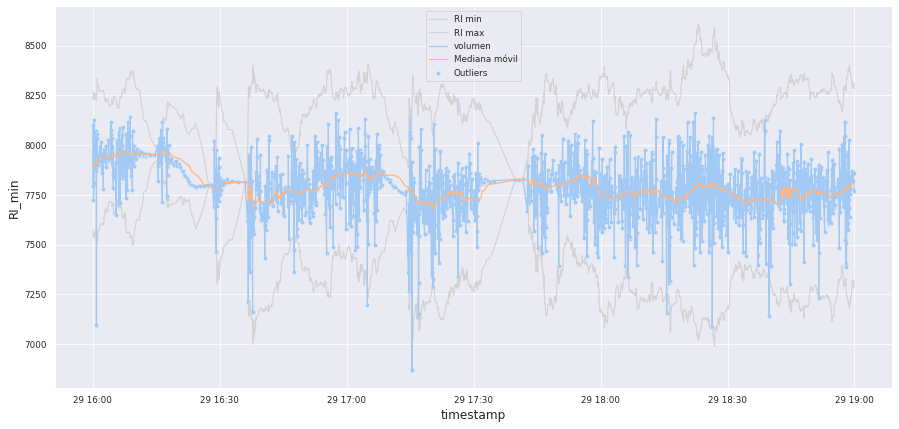

In [ ]:
fig = plt.figure(figsize=(15, 7))
seaborn.lineplot(
    data=sample, y='RI_min', x='timestamp',
    label='RI min', color='lightgray' 
)
seaborn.lineplot(
    data=sample, y='RI_max', x='timestamp', 
    label='RI max',  color='lightgray' 
)
seaborn.lineplot(
    data=sample, y='volumen', x='timestamp',
    label='volumen'
)
seaborn.lineplot(
    data=sample, y='moving_median', x='timestamp',
    label='Mediana móvil'
)
seaborn.scatterplot(
    data=sample_outlier, y='volumen', x='timestamp',
    label='Outliers',
)
plt.title(f'Inventario del tanque {id_tanque}')
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

Quitamos entonces los valores que superen el 1.5 veces el rango intercuarílico por ambos extremos.

In [ ]:
df = df.query("volumen >= RI_min")
df = df.query("volumen <= RI_max")
len(df)

6893287

Comparamos nuestra muestra antes y después de la eliminación de los puntos.

In [ ]:
sample_filtered = df.query("""
    id_tanque == @id_tanque \
    and timestamp > @before \
    and timestamp < @after
""")

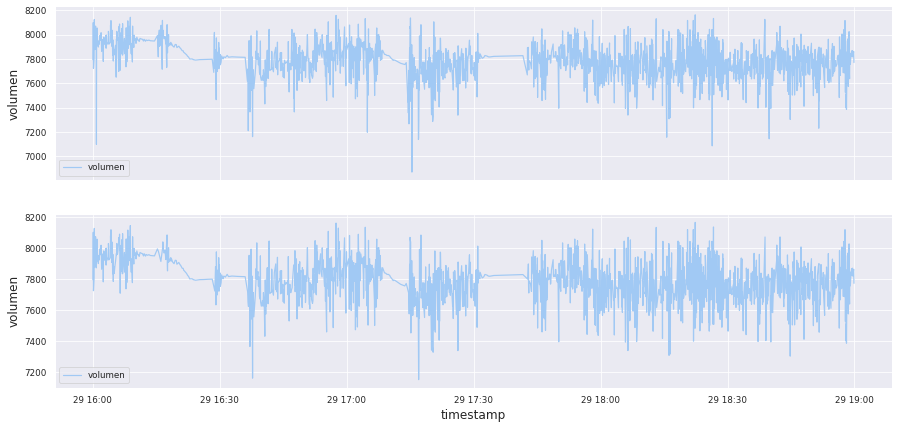

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(15, 7))
seaborn.lineplot(
    data=sample, y='volumen', x='timestamp',
    label='volumen', ax=axes[0]
)
seaborn.lineplot(
    data=sample_filtered, y='volumen', x='timestamp',
    label='volumen', ax=axes[1]
)
seaborn.scatterplot(
    data=sample_outlier, y='volumen', x='timestamp',
    label='volumen', color='crimsom', ax=axes[2]
)
axes[0].set_title(f'Tanque {id_tanque} antes del filtrado')
axes[1].set_title(f'Tanque {id_tanque} después del filtrado')
axes[2].set_title(f'Outliers eliminados del tanque {id_tanque}')
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

#### Filtrado de tanques con pocos datos

### Análisis de correlación entre las variables numéricas

In [ ]:
df_cor = df.corr(method="spearman")
df_cor

In [ ]:
plt.figure(figsize=(15,15))
seaborn.heatmap(df_cor, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

A partir del análisis de correlación entre las variables numéricas de nuestro dataset, pudimos observar una correlación alta entre las variables de temperatura ($r > 0.7$). Debido a que la feature temperatura representa los mismos valores que la feature `temp5`, sumado a que es la que indica la `temperatura` del combustible (a diferencia de las `temp1`, `temp2`, `temp3` y `temp4`) decidimos quedarnos con esta variable y desechar las otras. Por otra parte, observamos un alta correlación entre volumen y nivel de combustible ($r= 0.92$), que es lo que se espera ya que la variable volumen se calcula a partir de la variable nivel de combustible (`fuel_level_dmm`). De hecho, esperaríamos obtener una correlación igual a uno, sin embargo esta diferencia en el nivel de correlación podría deberse a un error de cálculo a partir de la tabla de calibración. En este caso, nos quedaríamos con la variable volumen ya que es la que nos aporta la información necesaria para responder a las preguntas planteadas. Por último, existe una correlación alta entre `volumen` y `capacidad` ($r = 0.82$), lo cual es esperable, sin embargo la variable `capacidad` nos provee información que la variable `valumen` no nos da, por lo que decidimos mantenerla en nuestro dataset por el momento.

### Comparacion de variables

#### Distribución de los valores de temperatura

Las sondas contienen sensores de temperatura ubicados a distintas alturas. Estos sensores se corresponden con las columnas `temp1`, `temp2`, `temp3`, `temp4`, `temp5`, siendo la primera (`temp1`) la que se encuentra más arriba y la última (`temp5`) la que se encuentra más cerca del fondo del tanque. Estas alturas no son equidistantes y no todas las sondas contienen todos los sensores, pero sabemos que al menos la última (`temp5`) siempre está presente en la sonda.

La columna `temperatura` es una copia de la columna `temp5`.

Además, el valor -56.6 nos indica que el sensor de esa temperatura no funciona correctamente o no está presente en la sonda.

In [ ]:
fig = plt.figure(figsize=(15, 7))
seaborn.boxplot(
    data=df[['temp1', 'temp2', 'temp3', 'temp4', 'temp5', 'temperatura']],
    color='lightblue'
)
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

#### Distribución de las capacidades



In [ ]:
fig = plt.figure(figsize=(15, 7))
seaborn.displot(
    data=df.groupby('id_tanque').first()['capacidad'],
    kde=True
)
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine(

Se puede observar una distribución multimodal.

### Selección de columnas relevantes

Una vez explorado nuestro dataset, viendo las correlaciones entre ellas y las distribuciones, eliminamos columnas que no serán relevantes para los siguientes análisis.

In [ ]:
df.drop(columns=['id', 'alarma', 'density'], inplace=True)

### Uniformidad de tiempo de los datos

A partir del siguiente análisis buscamos detectar gaps temporales entre muestras. El código presenta todos aquellos tanques (id_tanques) que presentan gaps entre muestras con más de 1 hora, junto a la media de los gaps y el desvío stándar. Oportunamente ajustaremos el gaps buscado en función de la frecuencia mínima requerida para la predección. 

In [ ]:
#se arma un array con los id_tanque
tanques_unique=df.id_tanque.unique()
for tanque in tanques_unique:
    # Tomar la diferencia del timestamp y no tener en cuenta la primer fila ya que no tiene diff hacia atrás
    deltas = df[df['id_tanque']==tanque].timestamp.diff()[1:]

    # Filtrar diffs mayores al valor introducido (pueden ser dias, horas, minutos, etc) 
    gaps = deltas[deltas > timedelta(hours=1)]

    #Resultados
    if len(gaps) != 0:
        print(f'Tanque ID:{tanque} tiene {len(gaps)} gaps con duración promedio: {gaps.mean()} y std: {gaps.std()}')
        #descomentar para ampliar información de los gaps
        #for i, g in gaps.iteritems():
        #    gap_start = df['timestamp'][i - 1]
        #    print(f'Start: {datetime.strftime(gap_start, "%Y-%m-%d")} | '
        #          f'Duration: {str(g.to_pytimedelta())}')

### Resampling del timeseries

Planteamos el resampleo de series de tiempo sobre distintas ventanas y distintos métodos. Se verá en mayor profundidad este tratamiento, en el práctico de curación.

In [ ]:
# 10 minutos
tanque_resampled = tanque.resample('10T').bfill()
tanque_resampled

In [ ]:
fig = plt.figure(figsize=(15, 7))
seaborn.lineplot(
    data=tanque_resampled[1400:1500], 
    y='volumen', 
    x='timestamp' 
)
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

### Agrupación de inventarios

Para poder visualizar correctamente un inventario en el tiempo es necesario poder separar los registros por tanque (o sonda) ya que cada registro es completamente independiente del resto de los casos.

Filtramos uno de los tanques por `id_tanque` y lo visualizamos.

In [ ]:
sample_tank = df.query("""
    id_tanque == '1014' \
    and timestamp > '2021-01-01' \
    and timestamp < '2021-01-02'
""")

In [ ]:
fig = plt.figure(figsize=(15, 5))
seaborn.lineplot(
    data=sample_tank, y='volumen', x='timestamp', 
    label='volumen'
)
plt.title(f'Inventario del tanque 1014')
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

Otras agrupaciones que pueden resultar útiles al momento de analizar características del dataset pueden ser por `producto`, `id_equipo`, `id_industria`, `id_canal`, rango de `capacidad`es.

### Normalización de valores

Para poder realizar algunas operaciones es necesario normalizar algunas de estas columnas. Se dejan algunas de ellas, las cuales serán cubiertas en profundidad en el trabajo de curación de datos.

#### Ajuste del `volumen` por dilatación térmica

El volumen aumenta o disminuye debido la **dilatación térmica**. Esta relación viene dada por:

<center>
$\alpha = {\Delta V\over V_0 \Delta T}$
</center>

donde:
- $T$ es la `temperatura`.
- $V$ es el `volumen`.

Este ajuste se realiza entonces comepensando el volumen a una temperatura seleccionada:

<center>
$V_f=\alpha*V_0*(T_f-T_0)$
</center>

donde:
- $T_0$ y $V_0$ son la `temperatura` y `volumen` registrados.
- $T_f$ es la temperatura a la cual compensar.
- $V_f$ es el volumen compensado.



#### Ajuste del `volumen` restando volumen de agua (`water_volume_lts`)

Si las sondas contienen dos boyas de medición, el `volumen` de combustible se ve afectado por la segunda medición (agua). Esto se puede ajustar restando el volumen del agua al volumen del combustible.

Adicionalmente el agua también puede ser ajustado por **dilatación térmica**.

## Análisis

Para esta etapa se procede a analizar los distintos inventarios agrupándolos por diferentes criterios.

### Descriptores estadísticos de los inventarios

### Inventarios sobre centros operativos

Se seleccionan algunos centros operativos para analizar el comportamiento de sus inventarios. Para esto, realizamos una selección aleatoria de la columna `id_equipo`.

### Patrones de manejo de inventario por industria

In [ ]:
df_ind=df[["volumen", "industria"]].groupby("industria").describe()
df_ind

In [ ]:
df_ind.columns = df_ind.columns.droplevel(level=0)
df_ind.sort_values(by='50%',ascending=False)

In [ ]:
plt.figure(figsize=(12,6))
seaborn.boxplot(data=df, x="industria", y="volumen")

In [ ]:
#Por hora

In [ ]:
df_ind_resa=df.groupby("industria").resample("1H", on="timestamp").mean().reset_index()
df_ind_resa


In [ ]:
df_ind_resa=df_ind_resa[(df_ind_resa["timestamp"] > "2021-01-01") & (df_ind_resa["timestamp"] < "2021-01-05")]
plt.figure(figsize=(15,15))
seaborn.lineplot(data=df_ind_resa, x="timestamp", y="volumen", hue="industria")

In [ ]:
#plt.figure(figsize=(15,15))
#seaborn.lineplot(data=df_ind_resa.rolling(24, center=True).mean(), x="timestamp", y="volumen", hue="industria")

In [ ]:
# Por día

In [ ]:
df_ind_resa=df.groupby("industria").resample("D", on="timestamp").mean().reset_index()
df_ind_resa

In [ ]:
df_ind_resa=df_ind_resa[(df_ind_resa["timestamp"] > "2021-01-01") & (df_ind_resa["timestamp"] < "2021-01-10")]


In [ ]:
plt.figure(figsize=(15,15))
seaborn.lineplot(data=df_ind_resa, x="timestamp", y="volumen", hue="industria")

In [ ]:
# Por mes

In [ ]:
df_ind_resa=df.groupby("industria").resample("M", on="timestamp").mean().reset_index()
df_ind_resa

In [ ]:
plt.figure(figsize=(15,15))
seaborn.lineplot(data=df_ind_resa, x="timestamp", y="volumen", hue="industria")

### Patrones de manejo de inventario por producto


In [ ]:
df_pro=df[["volumen", "nombre_producto"]].groupby("nombre_producto").describe()
df_pro

In [ ]:
df_pro.columns = df_pro.columns.droplevel(level=0)
df_pro.sort_values(by='50%',ascending=False)

In [ ]:
plt.figure(figsize=(12,6))#ver de agrupar productos, categorizaría primero porque sino el gráfico no dice nada (por ejemplo: diesel, gasoil, nafta y otros para los menos frecuentes)
seaborn.boxplot(data=df, x="nombre_producto", y="volumen")

In [ ]:
#Por hora

In [ ]:
df_pro_resa=df.groupby("nombre_producto").resample("1H", on="timestamp").mean().reset_index()
df_pro_resa

In [ ]:
plt.figure(figsize=(15,15))
seaborn.lineplot(data=df_pro_resa, x="timestamp", y="volumen", hue="nombre_producto")

In [ ]:
df_pro_resa=df_pro_resa[(df_pro_resa["timestamp"]>"2021-01-01") & ((df_pro_resa["timestamp"]<"2021-01-05"))]
plt.figure(figsize=(15,15))
seaborn.lineplot(data=df_pro_resa.rolling(24, center=True).mean(), x="timestamp", y="volumen", hue="nombre_producto")

In [ ]:
#Por día

In [ ]:
df_pro_resa=df.groupby("nombre_producto").resample("D", on="timestamp").mean().reset_index()
df_pro_resa

In [ ]:
df_pro_resa=df_pro_resa[(df_pro_resa["timestamp"]>"2021-01-01") & ((df_pro_resa["timestamp"]<"2021-01-10"))]


In [ ]:
plt.figure(figsize=(15,15))
seaborn.lineplot(data=df_pro_resa, x="timestamp", y="volumen", hue="nombre_producto")

In [ ]:
# Por mes

In [ ]:
df_pro_resa=df.groupby("nombre_producto").resample("M", on="timestamp").mean().reset_index()
df_pro_resa

In [ ]:
plt.figure(figsize=(15,15))
seaborn.lineplot(data=df_pro_resa, x="timestamp", y="volumen", hue="nombre_producto")

### Primera y segunda derivada del `volumen` en el tiempo

La primer derivada nos da información de los movimientos del `volumen` en el tiempo. Si el líquido sube, la pendiente es positiva, si es negativa, el líquido baja. Valores cercanos a cero nos indican poco movimiento, mientras que valores más grandes nos indican que el líquido se mueve en grandes cantidades.

In [ ]:
# Cálculo de diferencia entre valores para obtener la pendiente
df['volumen_diff'] = df.groupby('id_tanque')['volumen'].diff()

In [ ]:
# Seleccionamos un tanque en un rango de tiempo
id_tanque = '1014'

sample_tanque = df.query("""
    id_tanque == @id_tanque \
    and timestamp > '2021-01-01 02:00' \
    and timestamp < '2021-01-02 07:00'
""")

# Graficamos
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 7))
seaborn.lineplot(data=sample_tanque['volumen'], ax=axes[0])
seaborn.lineplot(data=sample_tanque['volumen_diff'], ax=axes[1])
axes[0].set_title(f"Inventario del tanque {id_tanque}")
axes[1].set_title(f"Primera derivada de volúmenes del tanque {}")
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

La segunda derivada nos puede indicar cuál es la aceleración del movimiento del tanque.

In [ ]:
# Cálculo de diferencia entre diferencias para obtener la aceleración
df['volumen_second_diff'] = df.groupby('id_tanque')['volumen_diff'].diff()

In [ ]:
# Seleccionamos un tanque en un rango de tiempo
id_tanque = '1014'

sample_tanque = df.query("""
    id_tanque == @id_tanque \
    and timestamp > '2021-01-01 02:00' \
    and timestamp < '2021-01-02 07:00'
""")

# Graficamos
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 7))
seaborn.lineplot(data=sample_tanque['volumen'], ax=axes[0])
seaborn.lineplot(data=sample_tanque['volumen_second_diff'], ax=axes[1])
axes[0].set_title(f"Inventario del tanque {id_tanque}")
axes[1].set_title(f"Segunda derivada de volúmenes del tanque {}")
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

### Consumos por unidad de tiempo por centro operativo

Para poder calcular los consumos, debemos sumar todas las diferencias negativas (primera derivada) por tanque de acuerdo a distintos rangos de tiempo. 

Seleccionamos los rangos de tiempo por hora, diario y mensual para calcular el consumo.

In [ ]:
df['period_hour'] = df['timestamp'].dt.to_period('H')
df['period_day'] = df['timestamp'].dt.to_period('D')
df['period_month'] = df['timestamp'].dt.to_period('M')

Sumamos la columna calculada `volumen_diff` agrupando por tanque y por periodo.

In [ ]:
# Nos quedamos con los valores negativos para facilitar la suma
df['neg_volumen_diff'] = numpy.where(
    df['volumen_diff'] < 0, 
    df['volumen_diff'].abs(), 
    0
)

In [ ]:
# Calculamos la suma por periodo y lo agregamos a una nueva columna
df['consumos_hourly'] = df\
    .groupby(['id_tanque', 'period_hour'])['neg_volumen_diff']\
    .transform('sum')
df['consumos_daily'] = df\
    .groupby(['id_tanque', 'period_day'])['neg_volumen_diff']\
    .transform('sum')
df['consumos_monthly'] = df\
    .groupby(['id_tanque', 'period_month'])['neg_volumen_diff']\
    .transform('sum')

Graficamos los cosunmos de un tanque de muestra.  

In [ ]:
id_tanque = '1014'

sample_tanque = df.query("""
    id_tanque == @id_tanque \
    and timestamp > '2021-01-01 02:00' \
    and timestamp < '2021-01-02 07:00'
""")

fig, axes = plt.subplots(4, 1, sharex=False, figsize=(15, 10))
seaborn.lineplot(
    y=sample_tanque['volumen'], 
    x=sample_tanque['timestamp'],
    ax=axes[0]
)
seaborn.barplot(
    y=sample_tanque['consumos_hourly'], 
    x=sample_tanque['period_hour'],
    ax=axes[1],
    color="salmon"
)
seaborn.barplot(
    y=sample_tanque['consumos_daily'], 
    x=sample_tanque['period_hour'],
    ax=axes[2],
    color="salmon"
)
seaborn.barplot(
    y=sample_tanque['consumos_monthly'], 
    x=sample_tanque['period_hour'],
    ax=axes[3],
    color="salmon"
)
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

A veces puede haber ruido en el volumen histórico de los tanques que pueden confundirse con movimientos de combustible, por lo tanto, no sería correcto utilizar las diferencias entre volúmenes en el tiempo sin ningún tratamiento previo. Necesitamos suavizar los registros para obtener las diferencias reales. Para obtener el cálculo de consumos más preciso se utilizan las **direfencias entre las medias móviles**, tratamiento que será cubierto más adelante en el práctico de curación. 

Una vez obtenido el consumo en distintos periodos de tiempo por tanque, agrupamos los tanques para obtener los consumos por centro operativo.

In [ ]:
# Calculamos la suma por periodo y lo agregamos a una nueva columna
df['consumos_centro_hourly'] = df\
    .groupby(['id_equipo', 'period_hour'])['consumos_hourly']\
    .transform('sum')
df['consumos_centro_daily'] = df\
    .groupby(['id_equipo', 'period_day'])['consumos_daily']\
    .transform('sum')
df['consumos_centro_monthly'] = df\
    .groupby(['id_equipo', 'period_month'])['consumos_monthly']\
    .transform('sum')

Graficamos los consumos de un centro operativo de muestra.

In [ ]:
id_equipo = '520'

sample_equipo = df.query("""
    id_equipo == @id_equipo \
    and timestamp > '2021-01-01 02:00' \
    and timestamp < '2021-01-02 07:00'
""")

fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15, 8))
seaborn.barplot(
    y=sample_equipo['consumos_centro_hourly'], 
    x=sample_equipo['period_hour'],
    ax=axes[0],
    color="salmon"
)
seaborn.barplot(
    y=sample_equipo['consumos_centro_daily'], 
    x=sample_equipo['period_hour'],
    ax=axes[1],
    color="salmon"
)
seaborn.barplot(
    y=sample_equipo['consumos_centro_monthly'], 
    x=sample_equipo['period_hour'],
    ax=axes[2],
    color="salmon"
)
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

### Patrones de consumo por industria

In [ ]:
# Por hora

In [ ]:
df_ind_resa=df.groupby("industria").resample("H", on="timestamp").mean().reset_index()

In [ ]:
df_ind_resa["consumos_hourly"]=df_ind_resa["volumen"].diff()

In [ ]:
#df_ind_resa=df_ind_resa[df_ind_resa["consumos_hourly"]<=0]

In [ ]:
df_ind_resa=df_ind_resa[(df_ind_resa['timestamp'] > '2021-01-01') & (df_ind_resa['timestamp'] < '2021-01-05')]
plt.figure(figsize=(15,15))
seaborn.lineplot(data=df_ind_resa, x="timestamp", y="consumos_hourly", hue="industria")


In [ ]:
# Por día

In [ ]:
df_ind_resa=df.groupby("industria").resample("D", on="timestamp").mean().reset_index()

In [ ]:
df_ind_resa["consumos_daily"]=df_ind_resa["volumen"].diff()

In [ ]:
#df_ind_resa=df_ind_resa[df_ind_resa["volumen"]<=0]

In [ ]:
df_ind_resa=df_ind_resa[(df_ind_resa['timestamp'] > '2021-01-01') & (df_ind_resa['timestamp'] < '2021-01-10')]
plt.figure(figsize=(15,15))
seaborn.lineplot(data=df_ind_resa, x="timestamp", y="consumos_dayle", hue="industria")

In [ ]:
# Por mes

In [ ]:
df_ind_resa=df.groupby("industria").resample("M", on="timestamp").mean().reset_index()

In [ ]:
df_ind_resa["consumos_monthly"]=df_ind_resa["volumen"].diff()

In [ ]:
#df_ind_resa=df_ind_resa[df_ind_resa["volumen"]<=0]

In [ ]:
plt.figure(figsize=(15,15))
seaborn.lineplot(data=df_ind_resa, x="timestamp", y="consumos_monthly", hue="industria")

### Patrones de consumo por producto

In [ ]:
# Por hora

In [ ]:
df_pro_resa=df.groupby("nombre_producto").resample("H", on="timestamp").mean().reset_index()

In [ ]:
df_pro_resa["consumos_hourly"]=df_pro_resa["volumen"].diff()

In [ ]:
#df_pro_resa=df_pro_resa[df_pro_resa["volumen"]<=0]

In [ ]:
df_pro_resa=df_pro_resa[(df_pro_resa['timestamp'] > '2021-01-01') & (df_pro_resa['timestamp'] < '2021-01-05')]
plt.figure(figsize=(15,15))
seaborn.lineplot(data=df_pro_resa, x="timestamp", y="consumos_hourly", hue="nombre_producto")

In [ ]:
# Por día

In [ ]:
df_pro_resa=df.groupby("nombre_producto").resample("D", on="timestamp").mean().reset_index()

In [ ]:
df_pro_resa["consumos_daily"]=df_pro_resa["volumen"].diff()

In [ ]:
#df_pro_resa=df_pro_resa[df_pro_resa["volumen"]<=0]

In [ ]:
df_pro_resa=df_pro_resa[(df_pro_resa['timestamp'] > '2021-01-01') & (df_pro_resa['timestamp'] < '2021-01-10')]
plt.figure(figsize=(15,15))
seaborn.lineplot(data=df_pro_resa, x="timestamp", y="consumos_daily", hue="nombre_producto")

In [ ]:
# Por mes

In [ ]:
df_pro_resa=df.groupby("nombre_producto").resample("M", on="timestamp").mean().reset_index()

In [ ]:
df_pro_resa["consumos_monthly"]=df_pro_resa["volumen"].diff()

In [ ]:
#df_pro_resa=df_pro_resa[df_pro_resa["volumen"]<=0]

In [ ]:
df_pro_resa=df_pro_resa[(df_pro_resa['timestamp'] > '2021-01-01') & (df_pro_resa['timestamp'] < '2021-01-10')]
plt.figure(figsize=(15,15))
seaborn.lineplot(data=df_pro_resa, x="timestamp", y="consumos_monthly", hue="nombre_producto")

### Análisis estadísitico de los consumos en general

### Análisis estadístico de los consumos por industria


Ver si los patrones de consumo de minería y telecomunicaciones son diferentes. Deberíamos explica por qué creemos encontrar diferencia entre estas dos industrias? Quizas para minería se necesite más combustible ya que se utilizan grandes maquinarias que insumen más combustible que las maquinarias que se emplean en telecomunicaciones. Igual con distintos productos, por ejemplo:  gas y nafta, el gas es más barato que la nafta por lo que podríamos esperar un mayor consumo de este 

In [ ]:
import scipy.stats

In [ ]:
df.industria.value_counts()

In [ ]:
Mineria=df[df.industria == "Mining"].volumen
Telcos= df[df.industria == "Telcos"].volumen

In [ ]:
Mineria.mean(),  Mineria.var(), Mineria.std(), Mineria.count()

In [ ]:
Telcos.mean(),  Telcos.var(), Telcos.std(), Telcos.count()

In [ ]:
scipy.stats.ttest_ind(Mineria, Telcos, equal_var = False)

In [ ]:
Mineria_consumo=df_ind_resa[df_ind_resa.industria == "Mining"].consumos_hourly
Telcos_consumo= df_ind_resa[df_ind_resa.industria == "Telcos"].consumos_hourly

In [ ]:
Mineria_consumo.mean(),  Mineria_consumo.var(), Mineria_consumo.std(), Mineria_consumo.count()

In [ ]:
Telcos_consumo.mean(),  Telcos_consumo.var(), Telcos_consumo.std(), Telcos_consumo.count()

In [ ]:
scipy.stats.ttest_ind(Mineria_consumo, Telcos_consumo, equal_var = False)

### Análisis estadístico de los consumos por producto

In [ ]:
df.nombre_producto.value_counts()

In [ ]:
Diesel=df[df.nombre_producto == "Diesel"].volumen
Nafta= df[df.nombre_producto == "Nafta"].volumen

In [ ]:
Diesel.mean(), Diesel.var(), Diesel.std(), Diesel.count()

In [ ]:
Nafta.mean(), Nafta.var(), Nafta.std(), Nafta.count()

In [ ]:
scipy.stats.ttest_ind(Diesel, Nafta, equal_var = False)

In [ ]:
Diesel_consumo=df_pro_resa[df_pro_resa.nombre_producto == "Diesel"].consumos_hourly
Nafta_consumo= df_pro_resa[df_pro_resa.nombre_producto == "Nafta"].consumos_hourly

In [ ]:
Diesel_consumo.mean(), Diesel_consumo.var(), Diesel_consumo.std(), Diesel_consumo.count()

In [ ]:
Nafta_consumo.mean(), Nafta_consumo.var(), Nafta_consumo.std(), Nafta_consumo.count()

In [ ]:
scipy.stats.ttest_ind(Diesel_consumo, Nafta_consumo, equal_var = False)

### Media móvil de inventarios para cada indsutria

La **media móvil** sobre el `volumen` nos muestra el inventario de forma suavizada. Para realizar el cálculo de la media móvil, se elige una ventana de tiempo.

Se selecciona un centro operativo por industria para realizar el análisis.

In [ ]:
df['moving_avg'] = df.groupby('id_tanque')['volumen'].transform(
    lambda x: x.rolling(window='2T', min_periods=2).mean()
)

### Media móvil de consumos para cada industria

In [ ]:
df['moving_avg'] = df.groupby('id_tanque')['consumos_hourly'].transform(
    lambda x: x.rolling(window='2T', min_periods=1, center=True).mean()
)

## Conclusiones

Cómo harían un cálculo simple para estimar inventarios en el corto plazo?

Ideas:
- Repetir Último valor visto.
- Drift (media de últimos valores vistos)
- Última pendiente
- Media movil de últimas pendientes
- última pendiente, y aplicar última aceleración (d' y d'')
- Media movil de últimas pendientes y aplicar mm de última aceleración
- Conjunto de últimos valores + último valor 

### Repetición del último valor visto en el tiempo.

### Último valor visto y media móvil

### Últimos valores vistos